<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# FIA Biomass Modeling

_by Jeremy Freeman (CarbonPlan), September 19, 2020_

This notebook extracts fits predictive biomass growth curves from FIA data

In [966]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [967]:
import numpy as np
import pandas as pd
from forests import load, setup, plot, fit

In [3]:
setup.plotting()

In [1013]:
df = load.fia(store='local', states='conus', wide=False)
df = load.terraclim(store='local', tlim=(2000,2020), mean=True, df=df)

In [1014]:
type_codes = df['type_code'].unique()

In [1028]:
foo = load.fia(store='local', states='CA', wide=False)

In [ ]:
# fit all models
models = {}
for i, code in enumerate(type_codes):
    print(i/len(type_codes))
    df_type = df[df['type_code'] == code].reset_index()
    if len(df_type) > 30:
        x = df_type['age']
        y = df_type['biomass']
        f = [df_type['tmax'], df_type['ppt']]
        model = fit.biomass(x=x, y=y, f=f, noise='gamma')
        models[code] = model
    else:
        print(code)

0.0


In [874]:
code

921.0

In [897]:
# evaluate predictions across target years

code = 221
inds = df['type_code'] == code

mf = pd.DataFrame()
mf['lat'] = df[inds]['lat']
mf['lon'] = df[inds]['lon']

targets = np.arange(2000,2100,5)
for it in range(len(targets)):
    x = df[inds]['age']
    year = df[inds]['year']
    f = [df[inds]['tmax'], df[inds]['ppt']]
    if it == 0:
        mf[targets[it]] = models[code].predict(np.maximum(x + (targets[it] - year), 0), f)
    else:
        diff = models[code].predict(x + (targets[it] - year), f) - models[code].predict(x + (targets[it-1] - year), f)
        mf[targets[it]] = np.maximum(mf[targets[it-1]] + diff, 0)

In [926]:
plt.plot?

In [937]:
from palettable.cubehelix import perceptual_rainbow_16
cmap = perceptual_rainbow_16.mpl_colormap

In [947]:
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

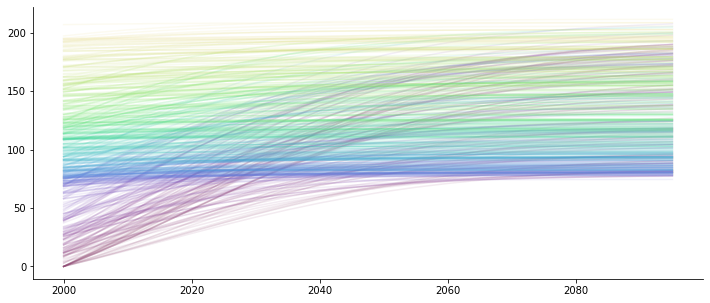

In [952]:
plt.figure(figsize=[12,5])
pf = mf[targets].sort_values(2000).reset_index(drop=True)
for row,value  in pf.iterrows():
    plt.plot(value, 'b', color=cmap(row/len(pf)), alpha=0.1);

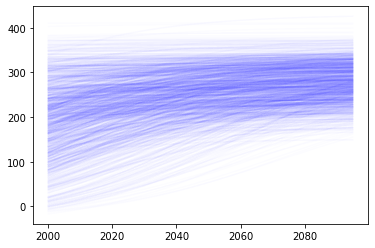

In [640]:
plt.plot(mf[targets].T, 'b', alpha=0.01);

(array([5., 6., 9., 6., 2., 1., 1., 3., 0., 1.]),
 array([0.06574386, 0.14561643, 0.22548899, 0.30536156, 0.38523413,
        0.4651067 , 0.54497926, 0.62485183, 0.7047244 , 0.78459697,
        0.86446954]),
 <a list of 10 Patch objects>)

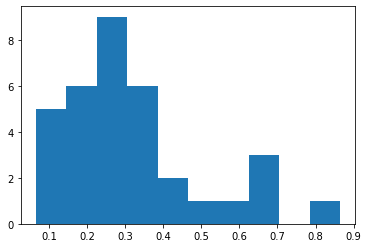

In [534]:
plt.hist([models[k].train_r2 for k in models.keys()])

In [347]:
code

704.0

In [797]:
df.groupby('type_code').agg(count=('type_code', 'count')).sort_values('count', ascending=False).T

type_code,503.0,161.0,901.0,801.0,201.0,520.0,185.0,406.0,221.0,809.0,...,910.0,360.0,364.0,260.0,300.0,320.0,342.0,129.0,396.0,220.0
count,27699,27498,15268,12726,12546,12453,9960,8226,7314,5958,...,2,2,2,2,1,1,1,1,1,1


In [1016]:
inds = df['type_code'] == 407 # 261 is a problem, 941 / 371 is a good example, 341 shows model deviation
x = df[inds]['age']
y = df[inds]['biomass']
f = [df[inds]['tmax'], df[inds]['ppt']]
(
plot.xy(x=x, y=y, color=f[0], xlim=[0,200], ylim=[0,500])
|
plot.xy(x=x, y=y, color=f[1], xlim=[0,200], ylim=[0,500])
).resolve_scale(color='independent')

alt.HConcatChart(...)

In [1017]:
model = fit.biomass(x=x, y=y, f=f, noise='gamma')

In [1018]:
model.r2(x, f, y)

0.3899306527959

In [1019]:
xlim = [0, 150]
ylim= [0, 300]
(
(
plot.xy(x=x, y=y, color=f[0], xlim=xlim, ylim=ylim)
+ plot.line(x=x, y=model.predict(x, f, [90, 50]), color=np.nanpercentile(f[0], 90), xlim=xlim, ylim=ylim)
+ plot.line(x=x, y=model.predict(x, f, [10, 50]), color=np.nanpercentile(f[0], 10), xlim=xlim, ylim=ylim)
)
|
(
plot.xy(x=x, y=y, color=f[1], xlim=xlim, ylim=ylim)
+ plot.line(x=x, y=model.predict(x, f, [50, 10]), color=np.nanpercentile(f[1], 10), xlim=xlim, ylim=ylim)
+ plot.line(x=x, y=model.predict(x, f, [50, 90]), color=np.nanpercentile(f[1], 90), xlim=xlim, ylim=ylim)
)
).resolve_scale(color='independent')

alt.HConcatChart(...)

In [884]:
xlim = [0,150]
ylim= [-100,400]
((plot.xy(x=x, y=y, xlim=xlim, ylim=ylim)
+ plot.line(x=x, y=model.predict(x, f, [50, 50]), xlim=xlim, ylim=ylim))
|
(plot.xy(x=x, y=model.sample(x, f), xlim=xlim, ylim=ylim)
+ plot.line(x=x, y=model.predict(x, f, [50, 50]), xlim=xlim, ylim=ylim)))

alt.HConcatChart(...)

In [230]:
plot.carto(lat=df['lat'], lon=df['lon'], color=df['biomass'], cmap='yellowgreen', clim=(0,200))

alt.Chart(...)

In [231]:
plot.carto(lat=df['lat'], lon=df['lon'], color=df['tmax'], cmap='plasma', clim=(5, 30))

alt.Chart(...)

In [26]:
import rasterio

In [254]:
r = rasterio.open('/Users/freeman/workdir/carbonplan-data/processed/nlcd/conus/4000m/2016_c42.tif')

In [255]:
a = r.read(1)

In [33]:
from showit import image
%matplotlib inline

In [202]:
a.shape

(783, 1209)

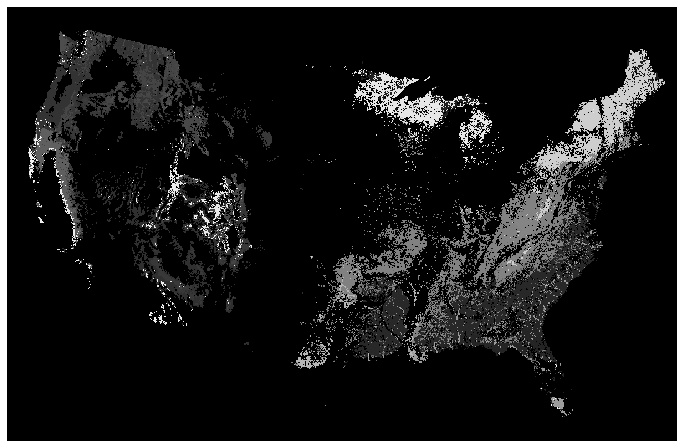

In [203]:
image(a, size=12)

In [204]:
from rasterio import Affine
from rasterio.transform import rowcol
from pyproj import transform, Proj
from carbonplan_data.utils import albers_conus_crs, albers_conus_transform

In [305]:
inds = df['year'] > 2010
df_sub = df[inds].reset_index()
t = Affine(*albers_conus_transform(4000))
p1 = Proj(albers_conus_crs())
p2 = Proj(proj='latlong', datum='WGS84')
x, y = transform(p2, p1, df_sub['lon'].values, df_sub['lat'].values)
rc = rowcol(t, x, y)

In [306]:
m = np.zeros(a.shape)
b = np.zeros(a.shape)

In [307]:
for i, (r, c) in enumerate(zip(rc[0],rc[1])):
    m[r, c] += 1
    b[r, c] += df_sub['biomass'][i]

In [220]:
m[rc[0], rc[1]] = df['biomass']

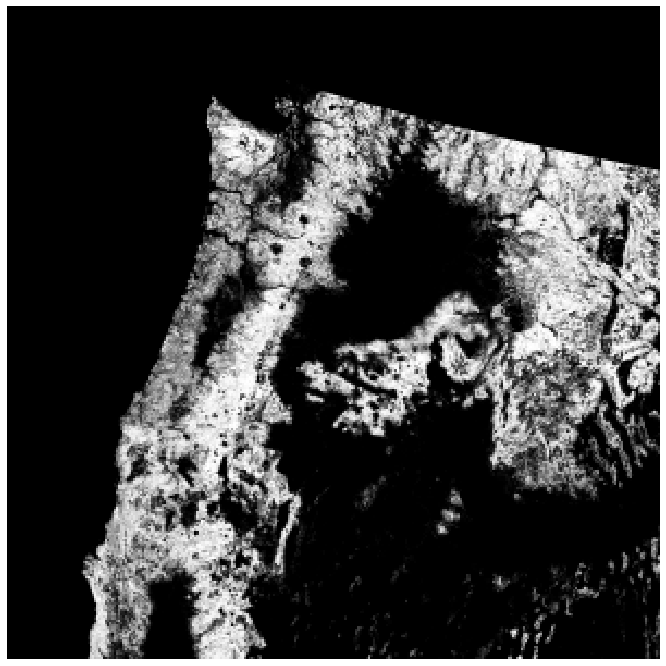

In [256]:
image(a[0:300,0:300], size=12)

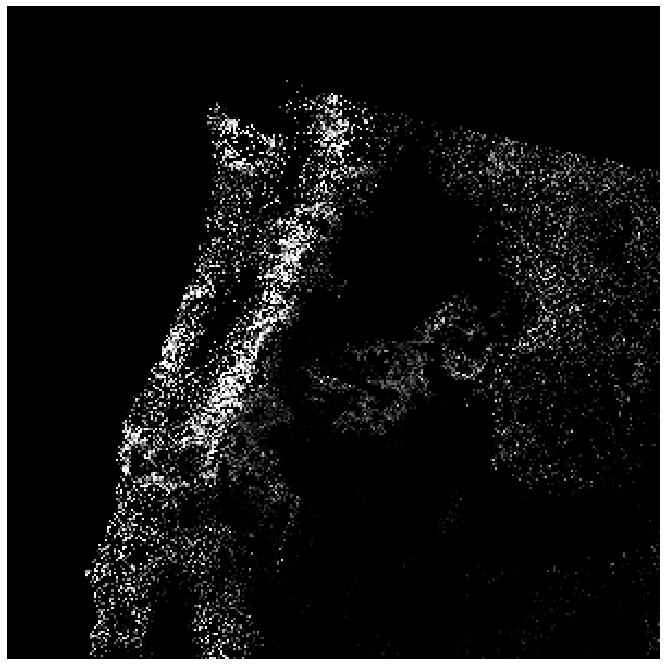

In [308]:
image(b[0:300,0:300] / m[0:300,0:300], clim=(0,400), size=12)

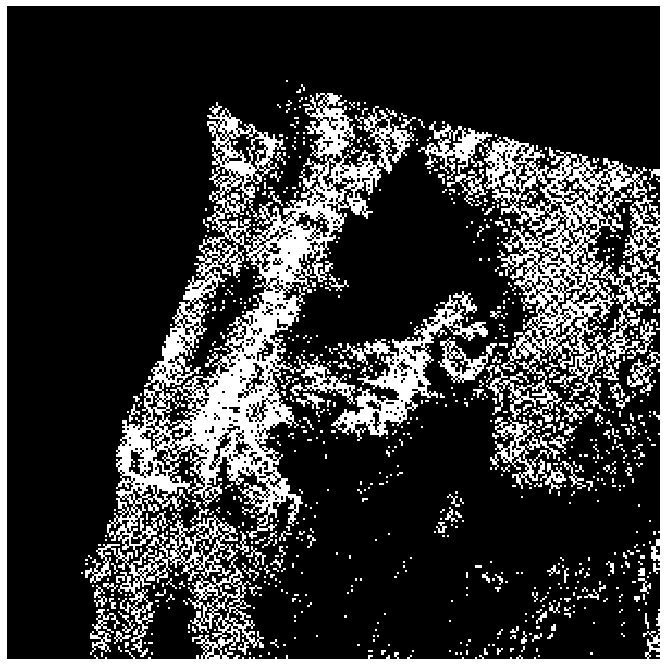

In [239]:
image(m[0:300,0:300], clim=(0,1), size=12)

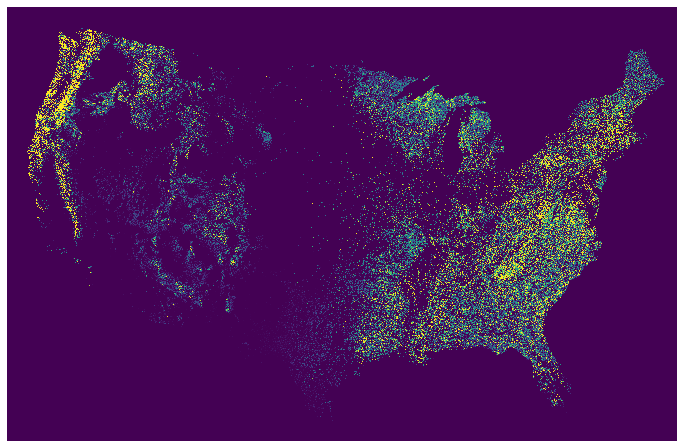

In [228]:
image(m, clim=(0,200), cmap='viridis', size=12)

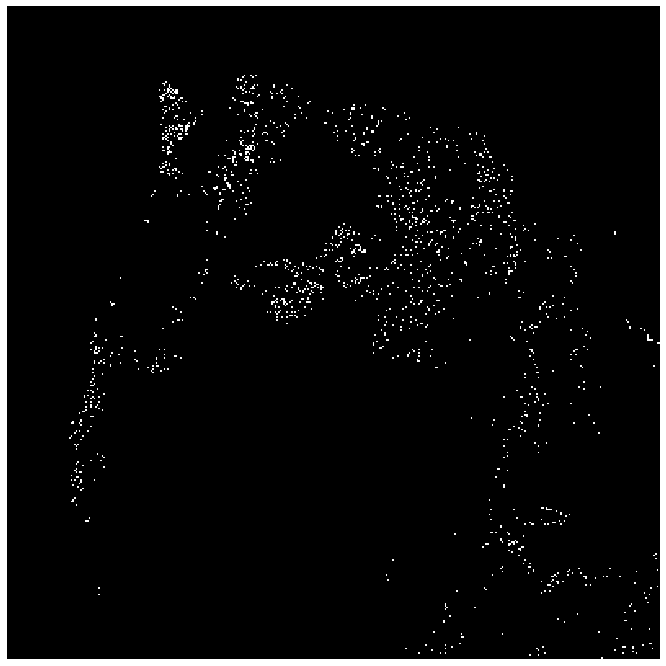

In [161]:
image((m[0:400,0:400]!=201) & (m[0:400,0:400]!=0), size=12)

In [164]:
np.unique(a[0:400,0:400])

array([  0, 182, 183, 184, 185, 201, 202, 221, 223, 224, 241, 261, 262,
       263, 264, 265, 266, 267, 268, 270, 281, 301, 304, 305, 321, 341,
       365, 366, 367, 368, 371, 703, 901, 902, 911, 912, 921, 922, 923,
       924, 925, 931, 932, 941, 942, 943, 951, 953, 954, 955],
      dtype=uint16)

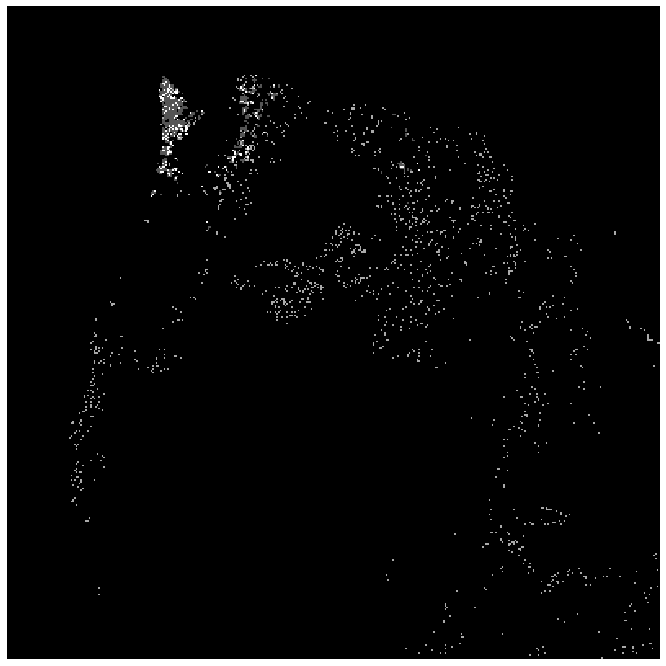

In [191]:
image(((m[0:400,0:400]!=201) & (m[0:400,0:400]!=0)) + 0.5*(a[0:400,0:400]==301), size=12)

In [102]:
import matplotlib.pyplot as plt

In [130]:
sum(types==df['type_code'])/len(types)

0.23516156654198025

In [121]:
plot.xy(x=types, y=df['type_code'])

alt.Chart(...)

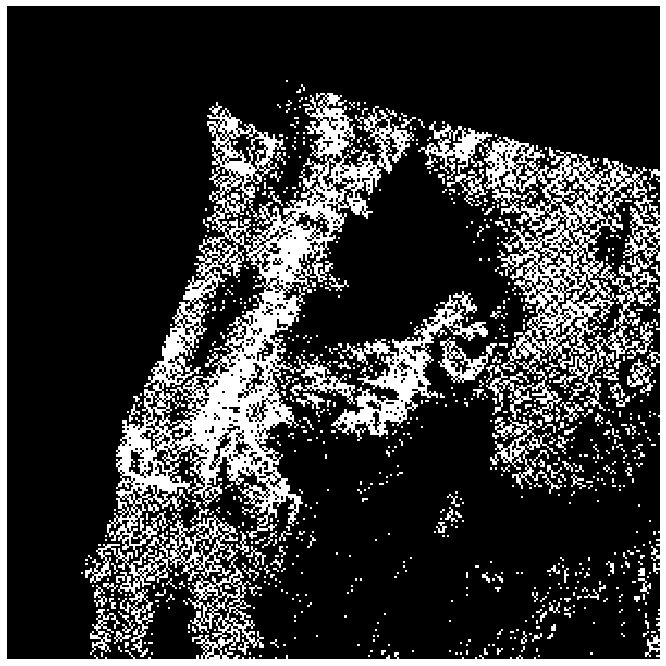

In [112]:
image(m[0:300,0:300], size=12)